In [5]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import ParameterGrid

ROOT = Path("")
DATA_DIR = ROOT / "data"
ARTIFACTS_DIR = ROOT / "artifacts"
FIGURES_DIR = ARTIFACTS_DIR / "figures"
LABELS_DIR = ARTIFACTS_DIR / "labels"
for p in (ARTIFACTS_DIR, FIGURES_DIR, LABELS_DIR):
    p.mkdir(parents=True, exist_ok=True)

RNG = 42 
plt.rcParams["figure.figsize"] = (7,5)


In [ ]:
def eda_df(df, name):
    print(f"--- EDA: {name} ---")
    display(df.head())
    print(df.info())
    print("describe():")
    display(df.describe(include='all').T)
    miss = df.isna().sum()
    print("Missing values (counts):")
    display(miss[miss>0])
    print("\n")

def build_numeric_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

def fit_preprocess(df, numeric_cols, categorical_cols=None):
    transformers = []
    transformers.append(("num", build_numeric_pipeline(), numeric_cols))
    if categorical_cols:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols))
    coltr = ColumnTransformer(transformers, remainder="drop")
    X = coltr.fit_transform(df)
    return X, coltr

def compute_internal_metrics(X, labels):
    unique = np.unique(labels)
    n_clusters = len([l for l in unique if l!=-1])
    metrics = {}
    try:
        if n_clusters >= 2:
            mask = (labels != -1)
            if mask.sum() >= 2 and len(np.unique(labels[mask])) >= 2:
                metrics['silhouette'] = silhouette_score(X[mask], labels[mask])
            else:
                metrics['silhouette'] = float("nan")
        else:
            metrics['silhouette'] = float("nan")
    except Exception as e:
        metrics['silhouette'] = float("nan")
    try:
        mask = (labels != -1)
        if mask.sum() >= 2 and len(np.unique(labels[mask])) >= 2:
            metrics['davies_bouldin'] = davies_bouldin_score(X[mask], labels[mask])
        else:
            metrics['davies_bouldin'] = float("nan")
    except:
        metrics['davies_bouldin'] = float("nan")
    try:
        mask = (labels != -1)
        if mask.sum() >= 2 and len(np.unique(labels[mask])) >= 2:
            metrics['calinski_harabasz'] = calinski_harabasz_score(X[mask], labels[mask])
        else:
            metrics['calinski_harabasz'] = float("nan")
    except:
        metrics['calinski_harabasz'] = float("nan")
    metrics['n_clusters'] = int(n_clusters)
    metrics['n_noise'] = int((labels == -1).sum())
    metrics['noise_fraction'] = float((labels == -1).sum() / labels.shape[0])
    return metrics

def save_labels_csv(sample_id, labels, outpath):
    df = pd.DataFrame({"sample_id": sample_id, "cluster_label": labels})
    df.to_csv(outpath, index=False)


In [8]:
# загрузка и EDA

files = {
    "ds1": DATA_DIR / "S07-hw-dataset-01.csv",
    "ds2": DATA_DIR / "S07-hw-dataset-02.csv",
    "ds3": DATA_DIR / "S07-hw-dataset-03.csv",
}

dfs = {}
for key, path in files.items():
    print("Loading", path)
    df = pd.read_csv(path)
    dfs[key] = df
    eda_df(df, key)


Loading data\S07-hw-dataset-01.csv
--- EDA: ds1 ---


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB
None
describe():


,count,mean,std,min,25%,50%,75%,max
sample_id,12000.0,5999.500000,3464.245950,0.000000,2999.750000,5999.500000,8999.250000,11999.000000
f01,12000.0,-2.424716,11.014315,-19.912573,-9.472623,-6.869404,0.523841,24.403381
f02,12000.0,19.107804,60.790338,-92.892652,-40.282955,54.069335,70.280739,112.229523
f03,12000.0,-0.222063,0.500630,-1.590979,-0.125145,-0.031753,0.054980,0.512277
f04,12000.0,-8.284501,59.269838,-134.303679,-48.345007,16.211728,28.067178,75.088604
f05,12000.0,-0.190717,7.026435,-11.869169,-5.132473,0.444730,3.942368,13.717091
f06,12000.0,0.962972,14.794713,-20.521164,-8.807706,-6.134169,2.334426,41.452857
f07,12000.0,0.033724,59.541782,-215.098834,-39.900520,-0.578494,39.719821,213.381767
f08,12000.0,0.007638,0.607053,-2.633469,-0.401483,0.005306,0.410132,2.490745


Missing values (counts):


Series([], dtype: int64)



Loading data\S07-hw-dataset-02.csv
--- EDA: ds2 ---


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None
describe():


,count,mean,std,min,25%,50%,75%,max
sample_id,8000.0,3999.500000,2309.545410,0.000000,1999.750000,3999.500000,5999.250000,7999.000000
x1,8000.0,0.478867,0.955138,-2.487352,-0.116516,0.490658,1.085263,2.987555
x2,8000.0,0.241112,0.663195,-2.499237,-0.242357,0.241092,0.726526,2.995553
z_noise,8000.0,0.110454,8.097716,-34.056074,-5.392210,0.132470,5.655605,29.460076


Missing values (counts):


Series([], dtype: int64)



Loading data\S07-hw-dataset-03.csv
--- EDA: ds3 ---


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
None
describe():


,count,mean,std,min,25%,50%,75%,max
sample_id,15000.0,7499.500000,4330.271354,0.000000,3749.750000,7499.500000,11249.250000,14999.000000
x1,15000.0,1.246296,4.592421,-9.995585,-1.782144,0.664226,4.435671,16.207863
x2,15000.0,1.033764,4.710791,-9.980853,-2.666393,1.831257,4.969630,14.271153
f_corr,15000.0,0.212776,1.530017,-5.212038,-0.966224,0.296508,1.390273,5.795876
f_noise,15000.0,-0.027067,2.506375,-8.785884,-1.731128,-0.052391,1.673831,11.266865


Missing values (counts):


Series([], dtype: int64)

In [9]:
# Определяем X, sample_id и колонки
datasets = {}
for key, df in dfs.items():
    df = df.copy()
    # Отделяем sample_id
    if 'sample_id' in df.columns:
        sample_id = df['sample_id'].values
        df_feats = df.drop(columns=['sample_id'])
    else:
        sample_id = np.arange(len(df))
        df_feats = df.copy()
    # автоклассификация типов
    numeric_cols = df_feats.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_feats.select_dtypes(include=['object','category']).columns.tolist()
    print(f"{key}: numeric_cols={numeric_cols}, categorical_cols={categorical_cols}")
    datasets[key] = {
        "df": df,
        "df_feats": df_feats,
        "sample_id": sample_id,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols
    }

ds1: numeric_cols=['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08'], categorical_cols=[]
ds2: numeric_cols=['x1', 'x2', 'z_noise'], categorical_cols=[]
ds3: numeric_cols=['x1', 'x2', 'f_corr', 'f_noise'], categorical_cols=[]


In [10]:
# preprocessing fit_transform (сохраним preprocessor)
for key, meta in datasets.items():
    df_feats = meta['df_feats']
    num = meta['numeric_cols']
    cat = meta['categorical_cols'] if meta['categorical_cols'] else None
    X, preproc = fit_preprocess(df_feats, num, cat)
    meta['X'] = X
    meta['preproc'] = preproc
    print(f"{key}: X shape = {X.shape}")

ds1: X shape = (12000, 8)
ds2: X shape = (8000, 3)
ds3: X shape = (15000, 4)


In [11]:
# KMeans search
k_range = range(2, 13)
kmeans_results = {}

for key, meta in datasets.items():
    X = meta['X']
    metrics_by_k = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=RNG, n_init=10)
        labels = km.fit_predict(X)
        metrics = compute_internal_metrics(X, labels)
        metrics_by_k[k] = metrics
    kmeans_results[key] = metrics_by_k
    # Сохраним лучшие по silhouette (но не обязательно финальный выбор)
    silhouettes = {k:metrics_by_k[k]['silhouette'] for k in metrics_by_k}
    best_k = max(silhouettes, key=lambda k: (np.nan_to_num(silhouettes[k], nan=-999)))
    print(f"{key} best_k_by_silhouette = {best_k}, silhouette = {silhouettes[best_k]}")


ds1 best_k_by_silhouette = 2, silhouette = 0.5216395622404242
ds2 best_k_by_silhouette = 2, silhouette = 0.3068610017701601
ds3 best_k_by_silhouette = 3, silhouette = 0.31554470037825183


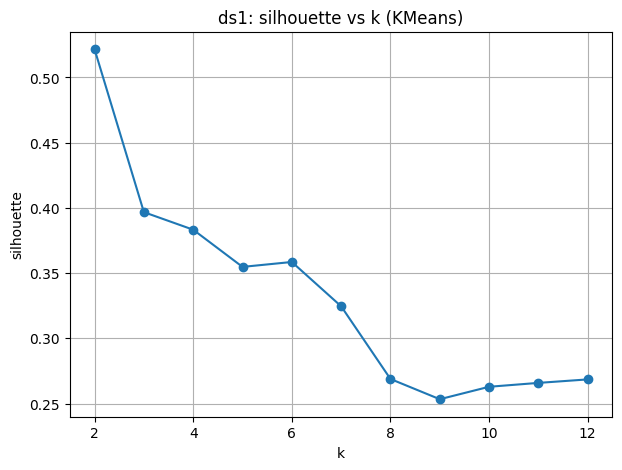

Saved: artifacts\figures\ds1_silhouette_vs_k.png


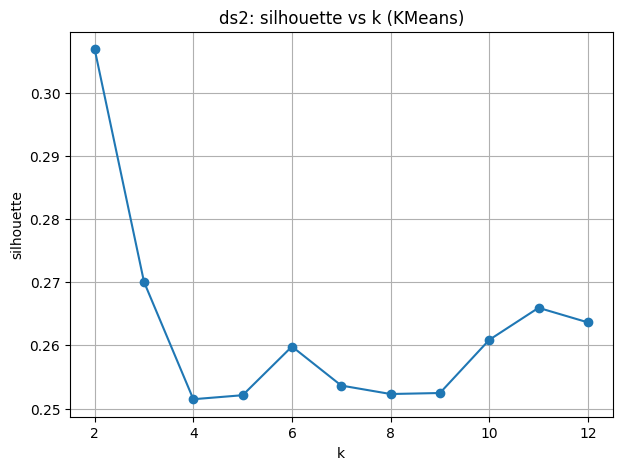

Saved: artifacts\figures\ds2_silhouette_vs_k.png


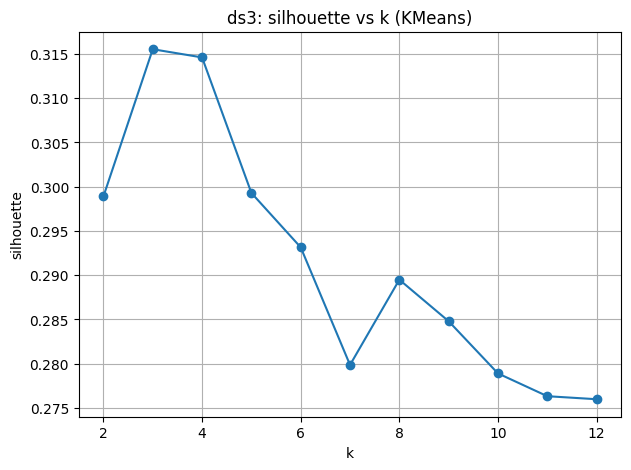

Saved: artifacts\figures\ds3_silhouette_vs_k.png


In [12]:
# графики plot silhouette vs k
for key in datasets:
    vals = [kmeans_results[key][k]['silhouette'] for k in k_range]
    plt.figure()
    plt.plot(list(k_range), vals, marker='o')
    plt.title(f"{key}: silhouette vs k (KMeans)")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True)
    out = FIGURES_DIR / f"{key}_silhouette_vs_k.png"
    plt.savefig(out, bbox_inches='tight')
    plt.show()
    print("Saved:", out)


In [13]:
# DBSCAN param search (примерный грид). 
# Важно: для каждого датасета eps зависит от масштаба, поэтому используем percentiles of pairwise distances to propose eps.
dbscan_results = {}

for key, meta in datasets.items():
    X = meta['X']
    # рассчитываем к-расстояния (k=4) для эвристики (k-distance), но не строим отдельно тут
    # Подбор eps: возьмём диапазон основанный на квантилях парных расстояний
    dists = pairwise_distances(X, metric='euclidean')
    # чтобы не хранить весь matrix (если очень большой), можно взять подвыборку; но синтетика — небольшая
    tri = dists[np.triu_indices_from(dists, k=1)]
    eps_candidates = np.percentile(tri, [1,2,5,10,20,30,40,50])
    eps_candidates = np.unique(eps_candidates)
    min_samps = [3,5,8]
    results = {}
    for eps in eps_candidates:
        for ms in min_samps:
            model = DBSCAN(eps=float(eps), min_samples=ms)
            labels = model.fit_predict(X)
            metrics = compute_internal_metrics(X, labels)
            results[(float(eps), ms)] = metrics
    dbscan_results[key] = results
    print(f"{key}: checked {len(results)} DBSCAN configs")


ds1: checked 24 DBSCAN configs
ds2: checked 24 DBSCAN configs
ds3: checked 24 DBSCAN configs


In [15]:
# выбрать лучшие конфигурации DBSCAN (по silhouette на non-noise)
best_dbscan = {}
for key, res in dbscan_results.items():
    best = None
    best_score = -999
    for (eps, ms), metrics in res.items():
        s = metrics['silhouette']
        if np.isnan(s):
            continue
        if s > best_score:
            best_score = s
            best = (eps, ms, metrics)
    best_dbscan[key] = best
    print(key, "best DBSCAN:", best)


ds1 best DBSCAN: (1.6816959596576166, 3, {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153, 'n_clusters': 2, 'n_noise': 0, 'noise_fraction': 0.0})
ds2 best DBSCAN: (0.7547388931955843, 8, {'silhouette': 0.4165021676113492, 'davies_bouldin': 0.6198031947643154, 'calinski_harabasz': 57.28051109487387, 'n_clusters': 2, 'n_noise': 100, 'noise_fraction': 0.0125})
ds3 best DBSCAN: (0.6829379747226404, 3, {'silhouette': 0.23178805292335014, 'davies_bouldin': 0.5965448640392205, 'calinski_harabasz': 12.874581209201862, 'n_clusters': 3, 'n_noise': 50, 'noise_fraction': 0.0033333333333333335})


In [16]:
# составим итоговую таблицу метрик и сохраним labels для лучших решений
metrics_summary = {}
best_configs = {}

for key, meta in datasets.items():
    X = meta['X']
    sample_id = meta['sample_id']
    # KMeans: выбираем best_k по silhouette из прошлой ячейки
    silhouettes = {k: kmeans_results[key][k]['silhouette'] for k in k_range}
    best_k = max(silhouettes, key=lambda k: (np.nan_to_num(silhouettes[k], nan=-999)))
    km = KMeans(n_clusters=best_k, random_state=RNG, n_init=10)
    labels_km = km.fit_predict(X)
    metrics_km = compute_internal_metrics(X, labels_km)
    # DBSCAN best (если найден)
    db_best = best_dbscan.get(key)
    if db_best is not None:
        eps, ms, db_metrics = db_best
        db_model = DBSCAN(eps=eps, min_samples=ms)
        labels_db = db_model.fit_predict(X)
        db_metrics = compute_internal_metrics(X, labels_db)
    else:
        labels_db = None
        db_metrics = None

    metrics_summary[key] = {
        "kmeans": {"k": int(best_k), **metrics_km},
        "dbscan": ({"eps": float(eps), "min_samples": int(ms), **db_metrics} if db_metrics else None)
    }
    best_configs[key] = {
        "kmeans": {"k": int(best_k), "random_state": RNG, "n_init": 10},
        "dbscan": ({"eps": float(eps), "min_samples": int(ms)} if db_metrics else None)
    }

    # Сохраняем labels (берём "лучшее" между KMeans и DBSCAN по silhouette на non-noise (если применимо))
    chosen_method = "kmeans"
    km_sil = metrics_km.get('silhouette', np.nan)
    db_sil = db_metrics.get('silhouette') if db_metrics else np.nan
    if not np.isnan(db_sil) and db_sil > km_sil:
        chosen_method = "dbscan"
        chosen_labels = labels_db
    else:
        chosen_labels = labels_km

    outlabels = LABELS_DIR / f"labels_hw07_{key}.csv"
    save_labels_csv(sample_id, chosen_labels, outlabels)
    print(f"{key}: chosen method = {chosen_method}, labels saved to {outlabels}")

# Сохранить metrics_summary.json и best_configs.json
with open(ARTIFACTS_DIR / "metrics_summary.json", "w") as f:
    json.dump(metrics_summary, f, indent=2)

with open(ARTIFACTS_DIR / "best_configs.json", "w") as f:
    json.dump(best_configs, f, indent=2)

print("Artifacts saved: metrics_summary.json, best_configs.json")


ds1: chosen method = kmeans, labels saved to artifacts\labels\labels_hw07_ds1.csv
ds2: chosen method = dbscan, labels saved to artifacts\labels\labels_hw07_ds2.csv
ds3: chosen method = kmeans, labels saved to artifacts\labels\labels_hw07_ds3.csv
Artifacts saved: metrics_summary.json, best_configs.json


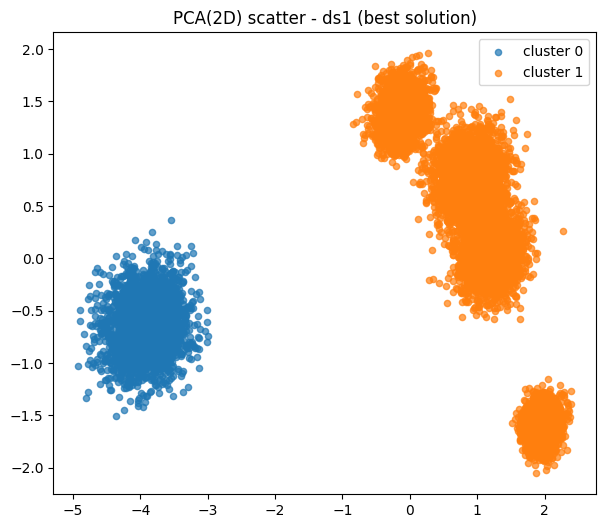

Saved: artifacts\figures\ds1_pca_best.png


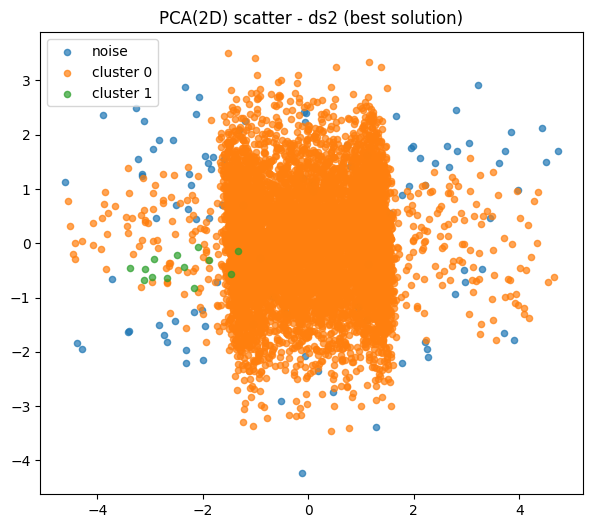

Saved: artifacts\figures\ds2_pca_best.png


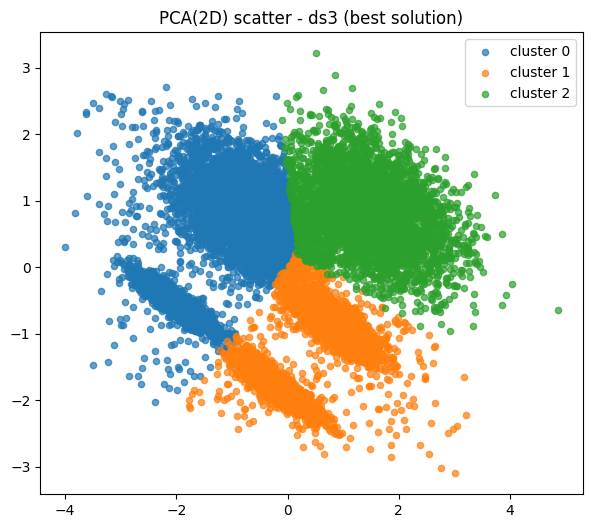

Saved: artifacts\figures\ds3_pca_best.png


In [17]:
# PCA scatter для каждого датасета по выбранному лучшему решению
for key, meta in datasets.items():
    X = meta['X']
    sample_id = meta['sample_id']
    # загрузим сохраненные метки
    labels_df = pd.read_csv(LABELS_DIR / f"labels_hw07_{key}.csv")
    labels = labels_df['cluster_label'].values
    pca = PCA(n_components=2, random_state=RNG)
    X2 = pca.fit_transform(X)
    plt.figure(figsize=(7,6))
    unique = np.unique(labels)
    for lab in unique:
        mask = labels == lab
        lbl = "noise" if lab == -1 else f"cluster {lab}"
        plt.scatter(X2[mask,0], X2[mask,1], label=lbl, s=20, alpha=0.7)
    plt.legend()
    plt.title(f"PCA(2D) scatter - {key} (best solution)")
    out = FIGURES_DIR / f"{key}_pca_best.png"
    plt.savefig(out, bbox_inches='tight')
    plt.show()
    print("Saved:", out)


**Итог (S07-hw-dataset-01).**

Лучший выбранный метод: **KMeans (k = 2)**. Обоснование: после стандартизации признаков KMeans дал компактные и отчётливые кластеры — silhouette = 0.5216, Davies–Bouldin = 0.6853, Calinski–Harabasz = 11786.95. DBSCAN при подобранных параметрах вернул схожее разбиение, то есть кластерная структура здесь близка к «сферической/равномерной», что хорошо ложится под допущения KMeans.

Проблемы и наблюдения: признаки исходно находятся в разных шкалах и есть шумовые признаки — без стандартизации результаты «уезжают». Удаление/снижение влияния шумовых признаков (feature selection) могло бы дополнительно улучшить четкость кластеров.

Короткий вывод: KMeans (k=2) — простое и обоснованное решение для этого датасета: высокие внутренние метрики и подтверждение устойчивости (см. раздел «Устойчивость», ARI).


**Итог (S07-hw-dataset-02).**

Лучший выбранный метод: **DBSCAN (eps = 0.7547, min_samples = 8)**. Обоснование: датасет содержит нелинейную структуру и отдельные выбросы, где KMeans (k = 2) имеет низкий silhouette = 0.3069. DBSCAN позволил выделить более плотные локальные кластеры и отнести выбросы в шум: DBSCAN silhouette = 0.4165, Davies–Bouldin = 0.6198 (улучшение). При этом Calinski–Harabasz упал (57.28) — это связано с пометкой части точек как шум, а также с малой межкластерной дисперсией для оставшихся кластеров.

Проблемы и наблюдения: подбор eps критичен — разные eps сильно меняют число кластеров и долю шума. В отчёте рекомендуется приложить k-distance plot и показать зависимость silhouette/DB от eps. DBSCAN хорошо справился с выбросами; поэтому он выбран как основной метод.

Короткий вывод: DBSCAN оказался более уместен для ds2, так как учитывает плотностные структуры и шум, несмотря на падение CH.


**Итог (S07-hw-dataset-03).**

Лучший выбранный метод: **KMeans (k = 3)** (обоснование практичности). Метрики: KMeans silhouette = 0.3155, Davies–Bouldin = 1.1577, Calinski–Harabasz = 6957.16. DBSCAN при подобранном eps выделил шум и дал более низкий DB (0.5965) но заметно ниже silhouette (0.2318) и низкий CH (12.87), что указывает на сильное снижение «активных» точек и/или мелкие плотные компоненты.

Проблемы и наблюдения: в датасете наблюдаются кластеры разной плотности и фоновой шум, что делает DBSCAN чувствительным к выбору eps (одно значение eps не покрывает все плотности одновременно). KMeans (k=3) дал более «устойчивое» (на практике) разбиение и лучше подходит, если требуется стабильная дискретизация на фиксированное число групп.

Короткий вывод: при переменной плотности KMeans (k=3) выбран как более интерпретируемый и практичный метод; DBSCAN показал интересные локальные разбиения, но требовал тонкой настройки eps.


In [21]:
# Устойчивость KMeans (ds1)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

key = "ds1"
X = datasets[key]['X']
k = best_configs[key]['kmeans']['k']

seeds = [1, 7, 13, 21, 99]  # 5 разных random_state
labels_list = []
for s in seeds:
    km = KMeans(n_clusters=int(k), random_state=int(s), n_init=10)
    labels = km.fit_predict(X)
    labels_list.append(labels)

# Считаем ARI между парами запусков и сохраняем матрицу
from itertools import combinations
pairs = list(combinations(range(len(seeds)), 2))
ari_pairs = []
for i,j in pairs:
    ari = adjusted_rand_score(labels_list[i], labels_list[j])
    ari_pairs.append(ari)

ari_mean = float(np.mean(ari_pairs))
ari_min = float(np.min(ari_pairs))
ari_max = float(np.max(ari_pairs))

print("ARI values (pairwise):", ari_pairs)
print(f"ARI mean = {ari_mean:.4f}, min = {ari_min:.4f}, max = {ari_max:.4f}")

out = ARTIFACTS_DIR / "stability_ds1_ari.json"
json.dump({"seeds": seeds, "pairwise_ari": ari_pairs, "ari_mean": ari_mean, "ari_min": ari_min, "ari_max": ari_max}, open(out, "w"))
print("Saved:", out)


ARI values (pairwise): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ARI mean = 1.0000, min = 1.0000, max = 1.0000
Saved: artifacts\stability_ds1_ari.json
